In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
pd.options.display.max_columns = 100

In [3]:
train = pd.read_csv("train_v9rqX0R.csv")
test  = pd.read_csv("test_AbJTz2l.csv")

In [4]:
Submission = test[['Item_Identifier','Outlet_Identifier']]

In [5]:
for df in [train,test]:
    df['Item_Fat_Content'].replace({"Low Fat":"Low_Fat","LF":"Low_Fat","low fat":"Low_Fat","reg":"Regular"},inplace=True)
    df['Item_Visibility'].replace({0:df['Item_Visibility'].mean()},inplace=True)
    df['Item_Weight'].fillna(df['Item_Weight'].median(),inplace=True)
    df['Outlet_Size'].fillna("Missing",inplace=True)
    df['Item_Identifier'] = df['Item_Identifier'].apply(lambda x: x[:2])
    df['Outlet_Establishment_Year'] = 2020 - df['Outlet_Establishment_Year']

In [6]:
# The following code creates grouped statistics and joins it with the main data frame (train). 
agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = train.groupby('Item_Fat_Content').agg(agg_func)
agg_func.columns = [ 'Item_Fat_Content_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
train = train.merge(agg_func, on=['Item_Fat_Content'], how='left')

agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = train.groupby('Item_Identifier').agg(agg_func)
agg_func.columns = [ 'Item_Identifier_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
train = train.merge(agg_func, on=['Item_Identifier'], how='left')

agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = train.groupby('Item_Type').agg(agg_func)
agg_func.columns = [ 'Item_Type_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
train = train.merge(agg_func, on=['Item_Type'], how='left')

In [7]:
# The following code creates grouped statistics and joins it with the main data frame (test).
agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = test.groupby('Item_Fat_Content').agg(agg_func)
agg_func.columns = [ 'Item_Fat_Content_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
test = test.merge(agg_func, on=['Item_Fat_Content'], how='left')

agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = test.groupby('Item_Identifier').agg(agg_func)
agg_func.columns = [ 'Item_Identifier_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
test = test.merge(agg_func, on=['Item_Identifier'], how='left')

agg_func = {
    'Item_MRP': ['mean','median','std']    
}
agg_func = test.groupby('Item_Type').agg(agg_func)
agg_func.columns = [ 'Item_Type_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
test = test.merge(agg_func, on=['Item_Type'], how='left')

In [8]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [9]:
# Separating the features from the target variable
X = train[[col for col in train.columns if col!="Item_Outlet_Sales"]]
y = train['Item_Outlet_Sales']

In [10]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X,y,test_size=0.25,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(6392, 55)
(6392,)
(2131, 55)
(2131,)


In [11]:
X_Train.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Item_MRP_mean,Item_Fat_Content_Item_MRP_median,Item_Fat_Content_Item_MRP_std,Item_Identifier_Item_MRP_mean,Item_Identifier_Item_MRP_median,Item_Identifier_Item_MRP_std,Item_Type_Item_MRP_mean,Item_Type_Item_MRP_median,Item_Type_Item_MRP_std,Item_Identifier_DR,Item_Identifier_FD,Item_Identifier_NC,Item_Fat_Content_Low_Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Missing,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.350,0.029565,256.4646,11,140.714098,142.0812,62.311756,141.622424,142.9470,61.664273,149.424753,153.3182,62.394009,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
7510,15.250,0.066132,179.7660,11,141.504259,144.0444,62.214786,142.135021,142.8786,62.291602,146.194934,146.6734,58.898002,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
5828,12.350,0.158716,157.2946,21,141.504259,144.0444,62.214786,142.135021,142.8786,62.291602,139.882032,146.5734,58.117456,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0
5327,7.975,0.014628,82.3250,16,140.714098,142.0812,62.311756,142.135021,142.8786,62.291602,126.380766,112.3544,58.059573,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0
4810,19.350,0.016645,120.9098,18,140.714098,142.0812,62.311756,142.135021,142.8786,62.291602,138.503366,128.6494,67.455074,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0


In [12]:
# Running a base decision tree model with default parameters
model_1 = DecisionTreeRegressor(random_state=42)
model_1.fit(X_Train,y_Train)

train_predictions = model_1.predict(X_Train)
test_predictions = model_1.predict(X_Test)

print ("Training RMSE is {}".format(np.sqrt(mean_squared_error(y_Train,train_predictions))))
print ("Training R-Squared is {}".format(r2_score(y_Train,train_predictions)))
print ("--------------------------------------------")
print ("Testing RMSE is {}".format(np.sqrt(mean_squared_error(y_Test,test_predictions))))
print ("Testing R-Squared is {}".format(r2_score(y_Test,test_predictions)))

Training RMSE is 4.925864104892086e-15
Training R-Squared is 1.0
--------------------------------------------
Testing RMSE is 1511.3317540687103
Testing R-Squared is 0.17211218774756598


We can clearly make out that themodel is overfitting, the training R Squared is a perfect 1 and the testing R Squared is 0.16. Even the RMSE values are wide apart, this is one of the major drawbacks of Decision Trees, they tend to overfit. Let us see how it performs after some hyperparameter tuning.

In [13]:
# Running a base decision tree model with hyperparameter tuning of max_depth
maximum_features = [0.5,'sqrt','log2',None,'auto']
for i in maximum_features:
    print ("Value of Maximum Features to be used is:",i)
    model_2 = DecisionTreeRegressor(max_features=i,random_state=42)
    model_2.fit(X_Train,y_Train)
    print ("For {} Maximum Depth, the training RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Train,model_2.predict(X_Train)))))
    print ("For {} Maximum Depth, the testing RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Test,model_2.predict(X_Test)))))
    print ("--------------------------------------------------")

Value of Maximum Features to be used is: 0.5
For 0.5 Maximum Depth, the training RMSE is:4.925864104892086e-15
For 0.5 Maximum Depth, the testing RMSE is:1501.6157445920537
--------------------------------------------------
Value of Maximum Features to be used is: sqrt
For sqrt Maximum Depth, the training RMSE is:0.0
For sqrt Maximum Depth, the testing RMSE is:1536.316297555021
--------------------------------------------------
Value of Maximum Features to be used is: log2
For log2 Maximum Depth, the training RMSE is:0.0
For log2 Maximum Depth, the testing RMSE is:1564.8713482942885
--------------------------------------------------
Value of Maximum Features to be used is: None
For None Maximum Depth, the training RMSE is:4.925864104892086e-15
For None Maximum Depth, the testing RMSE is:1511.3317540687103
--------------------------------------------------
Value of Maximum Features to be used is: auto
For auto Maximum Depth, the training RMSE is:4.925864104892086e-15
For auto Maximum De

We can see that with all other hyper parameters as defaults, max_depth of sqrt gave us the least Testing RMSE. Now let us tune the maximum depth parameter with the max_features as sqrt.

In [14]:
# Running a base decision tree model with hyperparameter tuning of max_depth
maximum_depth = list(range(4,12,2))
for i in maximum_depth:
    print ("Value of Maximum Features to be used is:",i)
    model_3 = DecisionTreeRegressor(max_features='sqrt',max_depth=i,random_state=42)
    model_3.fit(X_Train,y_Train)
    print ("For {} Maximum Depth, the training RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Train,model_3.predict(X_Train)))))
    print ("For {} Maximum Depth, the testing RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Test,model_3.predict(X_Test)))))
    print ("--------------------------------------------------")

Value of Maximum Features to be used is: 4
For 4 Maximum Depth, the training RMSE is:1391.870540751605
For 4 Maximum Depth, the testing RMSE is:1330.6659527725678
--------------------------------------------------
Value of Maximum Features to be used is: 6
For 6 Maximum Depth, the training RMSE is:1401.4738183852382
For 6 Maximum Depth, the testing RMSE is:1352.5350578147836
--------------------------------------------------
Value of Maximum Features to be used is: 8
For 8 Maximum Depth, the training RMSE is:1291.8026266119164
For 8 Maximum Depth, the testing RMSE is:1310.4550988561336
--------------------------------------------------
Value of Maximum Features to be used is: 10
For 10 Maximum Depth, the training RMSE is:1078.1089139238984
For 10 Maximum Depth, the testing RMSE is:1216.2807863742041
--------------------------------------------------


We can see a significant reduction in both Training and Testing RMSE, now this may also be the case of overfitting as I have run the model many times and the model kind of memorizes the data and spits out the values. We can see that a maximum depth of 10 gave us the least RMSE values.

In [15]:
# Running a base decision tree model with hyperparameter tuning of min_samples_leaf
min_samples_leaf = [1,3,5,7,10,15]
for i in min_samples_leaf:
    print ("Value of Maximum Features to be used is:",i)
    model_4 = DecisionTreeRegressor(max_features='sqrt',max_depth=10,random_state=42,min_samples_leaf=i)
    model_4.fit(X_Train,y_Train)
    print ("For {} Minimum Samples in the leaf node, the training RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Train,model_4.predict(X_Train)))))
    print ("For {} Minimum Samples in the leaf node, the testing RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Test,model_4.predict(X_Test)))))
    print ("--------------------------------------------------")

Value of Maximum Features to be used is: 1
For 1 Minimum Samples in the leaf node, the training RMSE is:1078.1089139238984
For 1 Minimum Samples in the leaf node, the testing RMSE is:1216.2807863742041
--------------------------------------------------
Value of Maximum Features to be used is: 3
For 3 Minimum Samples in the leaf node, the training RMSE is:1264.2321118741525
For 3 Minimum Samples in the leaf node, the testing RMSE is:1268.0981503606433
--------------------------------------------------
Value of Maximum Features to be used is: 5
For 5 Minimum Samples in the leaf node, the training RMSE is:1122.8957784352906
For 5 Minimum Samples in the leaf node, the testing RMSE is:1174.73303764166
--------------------------------------------------
Value of Maximum Features to be used is: 7
For 7 Minimum Samples in the leaf node, the training RMSE is:1119.3821183419702
For 7 Minimum Samples in the leaf node, the testing RMSE is:1187.008027284221
------------------------------------------

We can see a Minimum Samples in the leaf of 5 gave us the least RMSE values. We will use this and tune the next hyperparameter that is Minimum Samples Split

In [16]:
# Running a base decision tree model with hyperparameter tuning of min_samples_leaf
min_samples_split = [2,5,7,10,15,20,25,50]
for i in min_samples_split:
    print ("Value of Maximum Features to be used is:",i)
    model_5 = DecisionTreeRegressor(max_features='sqrt',max_depth=10,random_state=42,min_samples_leaf=5,min_samples_split=i)
    model_5.fit(X_Train,y_Train)
    print ("For {} Minimum Samples needed to split, the training RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Train,model_5.predict(X_Train)))))
    print ("For {} Minimum Samples needed to split, the testing RMSE is:{}".format(i,np.sqrt(mean_squared_error(y_Test,model_5.predict(X_Test)))))
    print ("--------------------------------------------------")

Value of Maximum Features to be used is: 2
For 2 Minimum Samples needed to split, the training RMSE is:1122.8957784352906
For 2 Minimum Samples needed to split, the testing RMSE is:1174.73303764166
--------------------------------------------------
Value of Maximum Features to be used is: 5
For 5 Minimum Samples needed to split, the training RMSE is:1122.8957784352906
For 5 Minimum Samples needed to split, the testing RMSE is:1174.73303764166
--------------------------------------------------
Value of Maximum Features to be used is: 7
For 7 Minimum Samples needed to split, the training RMSE is:1122.8957784352906
For 7 Minimum Samples needed to split, the testing RMSE is:1174.73303764166
--------------------------------------------------
Value of Maximum Features to be used is: 10
For 10 Minimum Samples needed to split, the training RMSE is:1122.8957784352906
For 10 Minimum Samples needed to split, the testing RMSE is:1174.73303764166
--------------------------------------------------
V

We can either tune each parameter individually, or use a GridSearch or Randomized search to fine tune the hyperparameters.

In [17]:
regressor = DecisionTreeRegressor(random_state=42)
search_params = {"max_features":[0.5,'sqrt','log2','auto',None],
                 "max_depth":list(range(4,12,2)),
                 "min_samples_split":[2,5,7,10,15,20,25,50],
                 "min_samples_leaf":[1,3,5,7,10,15]}
search = GridSearchCV(estimator=regressor,param_grid=search_params,cv=5,scoring="neg_root_mean_squared_error")
search.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'max_features': [0.5, 'sqrt', 'log2', 'auto', None],
                         'min_samples_leaf': [1, 3, 5, 7, 10, 15],
    

In [18]:
# We can check the best parameters, scores etc

In [19]:
search.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=15, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [20]:
search.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 50}

In [21]:
search.best_score_

-1096.3788911420068

In [22]:
# We can see a significant reduction in the RMSE value when the hyperparameters are tuned.

#### Visualizing the Tree

In [23]:
model = DecisionTreeRegressor(max_depth=3,random_state=42)
model.fit(X_Train,y_Train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

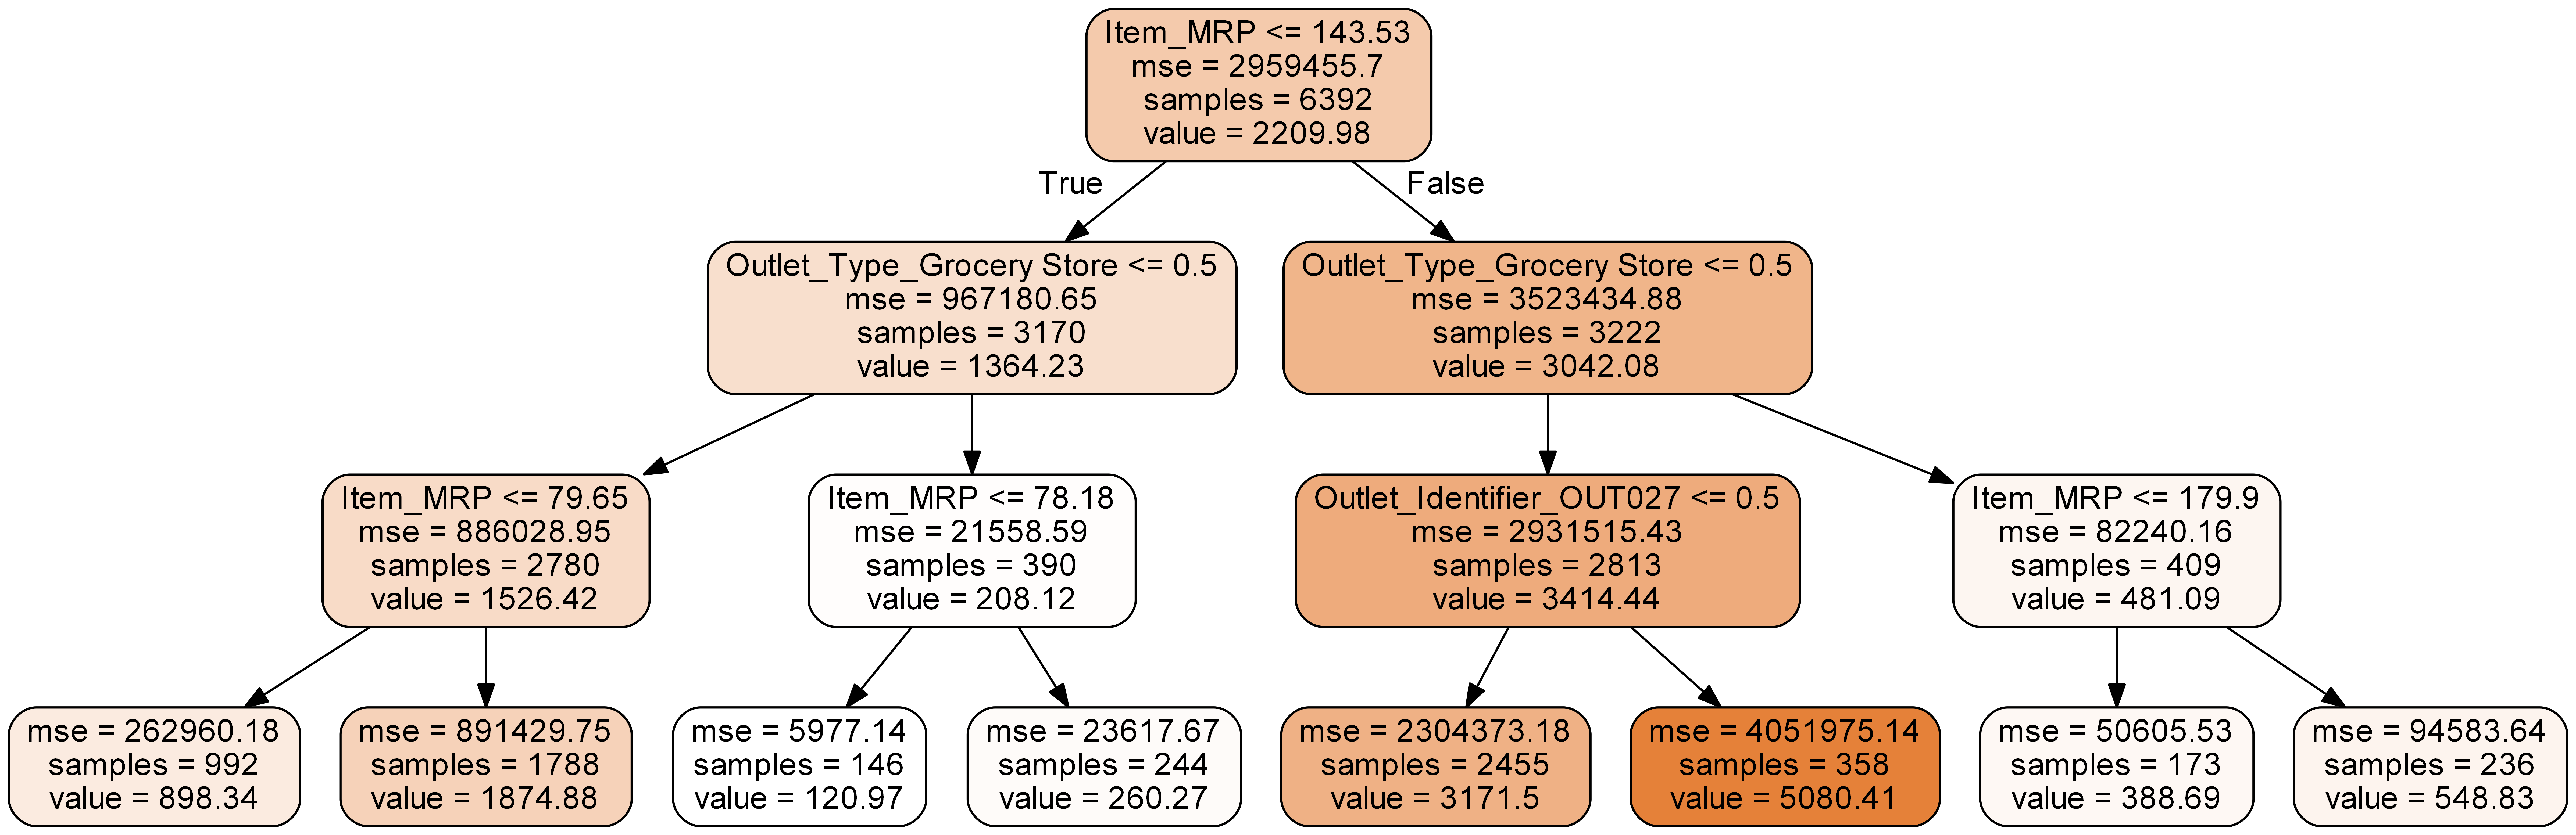

In [24]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(model, out_file='tree.dot', 
                feature_names = X.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

A full decision tree will not fit into the screen, so this is a sample decision tree with a maximum depth of just 3. We can see that the tree started building using Item_MRP as the first variable to split and then followed up with other variables. Each box has the information about the split point, the mean squared error value in that node, the number of samples in the node and the average Item_Sale price in that node. We can see that there are 8 leaf nodes in this decision tree. 